### Problem Statement

We want to model the number of bacteria grown in a set time interval, $y$. For this we have two features.

$$
x_{\textrm{temprature}} \in \mathbb{R}
$$

$$
x_{\textrm{humidity}} =
    \begin{cases}
      1 & \text{if humidity $> 80\%$}\\
      0 & \text{if humidity $\leq 80\%$}
    \end{cases}  
$$

Firstly, we examine the data to find a suitable model.

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

# Plotting configuration
%config InlineBackend.figure_format = 'retina'
plt.style.use(['science', 'notebook', 'grid'])

In [2]:
df = pd.read_csv('data/exponential_regression.csv')
[bacteria, temp, humidity] = df[['bacteria_grown', 'tempreature', 'humiditiy']]
df.head()

,bacteria_grown,tempreature,humiditiy
0,80750.679832,24.817575,1
1,33842.079471,23.825936,0
2,194891.669321,23.268858,1
3,15359.851544,21.030399,1
4,64627.861059,23.704124,0


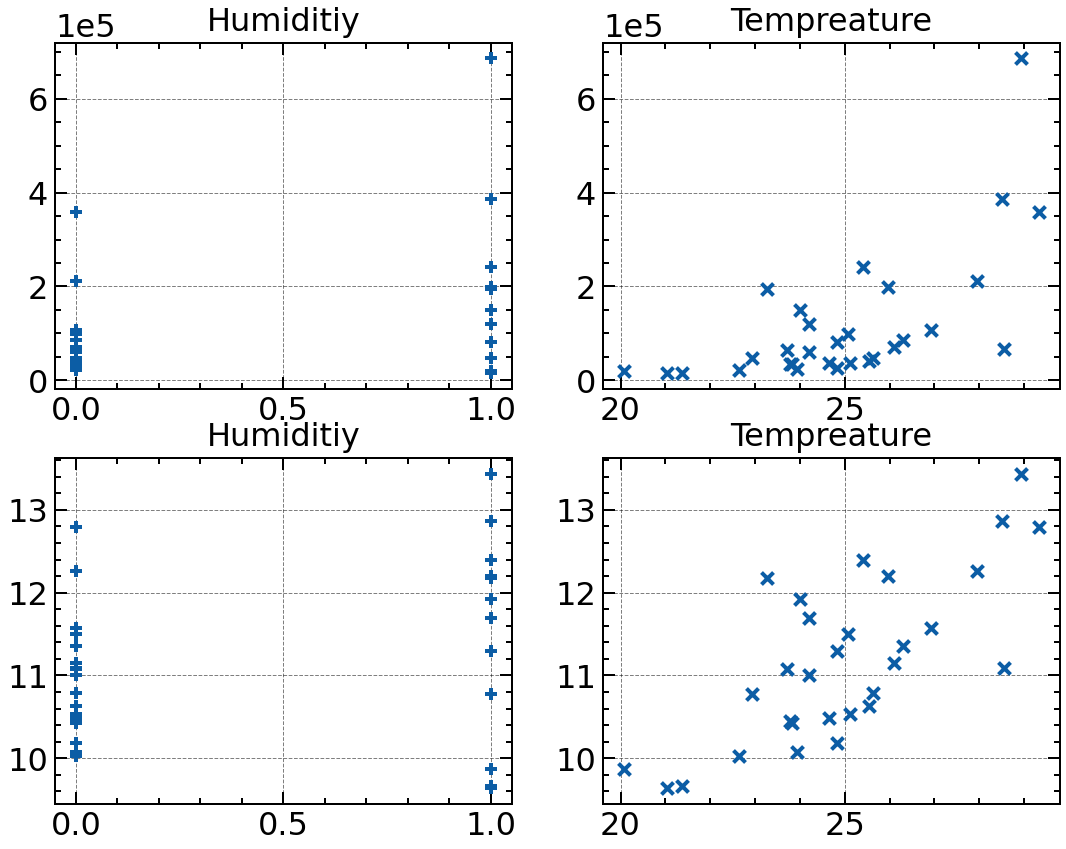

In [3]:
fig, axs = plt.subplots(2, 2)

axs[0, 0].scatter(df['humiditiy'], df['bacteria_grown'], marker='+')
axs[0, 0].set_title('Humiditiy')
axs[0, 0].ticklabel_format(axis='y', style='sci', scilimits=(5, 5))

axs[1, 0].scatter(df['humiditiy'], np.log(df['bacteria_grown']), marker='+')
axs[1, 0].set_title('Humiditiy')

axs[0, 1].scatter(df['tempreature'], df['bacteria_grown'], marker='x')
axs[0, 1].set_title('Tempreature')
axs[0, 1].ticklabel_format(axis='y', style='sci', scilimits=(5, 5))

axs[1, 1].scatter(df['tempreature'], np.log(df['bacteria_grown']), marker='x')
axs[1, 1].set_title('Tempreature')

fig.set_size_inches(9, 7)
plt.show()

### Model Selection

Since the data is exponential with respect to the features. We can simply modify the problem statement by examining the log-transformed data instead. This way we can utilize linear regression models to find an exponential curve that best fits the data. This is acceptable since the transformation $f(z) = e^z$ is a bijection. Therefore our regression model becomes:

$$
Y_i = \exp\big\{\beta_0 + \beta_1 x_{\text{temp}} + \beta_2 x_{\text{humidity}} + \varepsilon_i \big\} \iff Z_i \triangleq \ln Y_i = \beta_0 + \beta_1 x_{\text{temp}} + \beta_2 x_{\text{humidity}} + \varepsilon_i
$$

In the coming section we solve to normal equations to obtain the OLS estimate of $\hat{\mathbf{\beta}}$ and plot the resulting regression line and print its $R^2$ and $R_{\text{adj}}^2$ values.

Recall, the normal equations:
$$
\hat{\mathbf{\beta}} =\mathbf{X}^{\dagger}\mathbf{Z} = (\mathbf{X}^{\text{T}}\mathbf{X})^{-1}\mathbf{X}^{\text{T}}\mathbf{Z}
$$

And the definition of the explanatory power:

$$
R^2 = 1 - \frac{\text{SSE}}{\text{SST}}
$$

$$
R_{\text{adj}}^2 = 1 - \frac{\text{SSE} / (n-k-1)}{\text{SST} / (n - 1)} 
$$

In which:

$$
\text{SST} = \sum_{i=1}^n(z_i - \bar{z})^2
$$
$$
\text{SSE} = \sum_{i=1}^n(z_i - \hat{z}_i)^2
$$

In [8]:
# Creating design matrix.
n_observations = len(df)
x0 = np.ones(n_observations)
x1 = np.array(df['tempreature'])
x2 = np.array(df['humiditiy'])

X = np.stack([x0, x1, x2]).T
Z = np.array(np.log(df['bacteria_grown']))

# Solving normal equations.
beta_ols = np.linalg.inv(X.T @ X) @ X.T @ Z
H_hat = X @ np.linalg.inv(X.T @ X) @ X.T 

# R2 and Adjusted R2 values.
Z_sst = Z - np.mean(Z)
Z_sse = Z - H_hat @ Z
sst = Z_sst.T @ Z_sst
sse = Z_sse.T @ Z_sse

n_features = 2

r2 = 1 - sse/sst
r2_adj = 1 - (sse/(n_observations - n_features - 1))/(sst/(n_observations - 1))

print('OLS beta coefficients: ', beta_ols)
print('R squared: ', r2)
print('Adjusted R squared: ', r2_adj)

OLS beta coefficients:  [1.17201041 0.38493266 1.00574571]
R squared:  0.7812378089302527
Adjusted R squared:  0.7650332021843456


Given the model above, we can now plot the regression line in the bacteria-temperature plane. Both for the log-transformed values and for the non-transformed values.

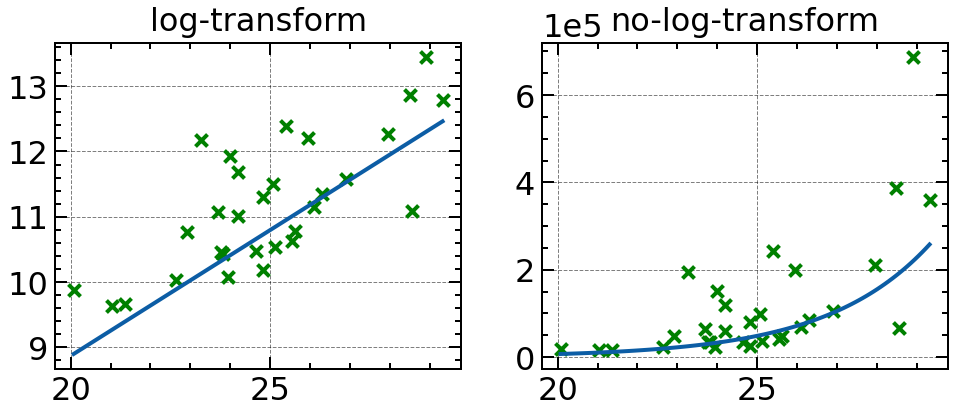

In [5]:
fig, axs = plt.subplots(1, 2)
x = df['tempreature']
x = np.linspace(np.min(x), np.max(x), 100)
z = beta_ols[0] + beta_ols[1] * x
y = np.exp(z)

axs[0].set_title('log-transform')
axs[0].scatter(df['tempreature'], np.log(df['bacteria_grown']), marker='x', color='green')
axs[0].plot(x, z)

axs[1].set_title('no-log-transform')
axs[1].scatter(df['tempreature'], df['bacteria_grown'], marker='x', color='green')
axs[1].plot(x, y)
axs[1].ticklabel_format(axis='y', style='sci', scilimits=(5, 5))

fig.set_size_inches(8, 3)
plt.show()

### Residual Analysis

For linear regression to work, we need to check the assumptions of the model after it has been fitted to the data. The three assumptions that need to be check is that:

* The residuals have constant variance 
* The residuals are independent from the features
* The residuals are normally distributed

Residuals can be calculated as:
$$
\mathbf{e} = \mathbf{Z} - \hat{\mathbf{Z}} = (\mathbf{I} - \mathbf{H})\mathbf{Z}, \quad \mathbf{H} = \mathbf{X}(\mathbf{X}^{\text{T}}\mathbf{X})^{-1}\mathbf{X}^{\text{T}}
$$

This is done below.

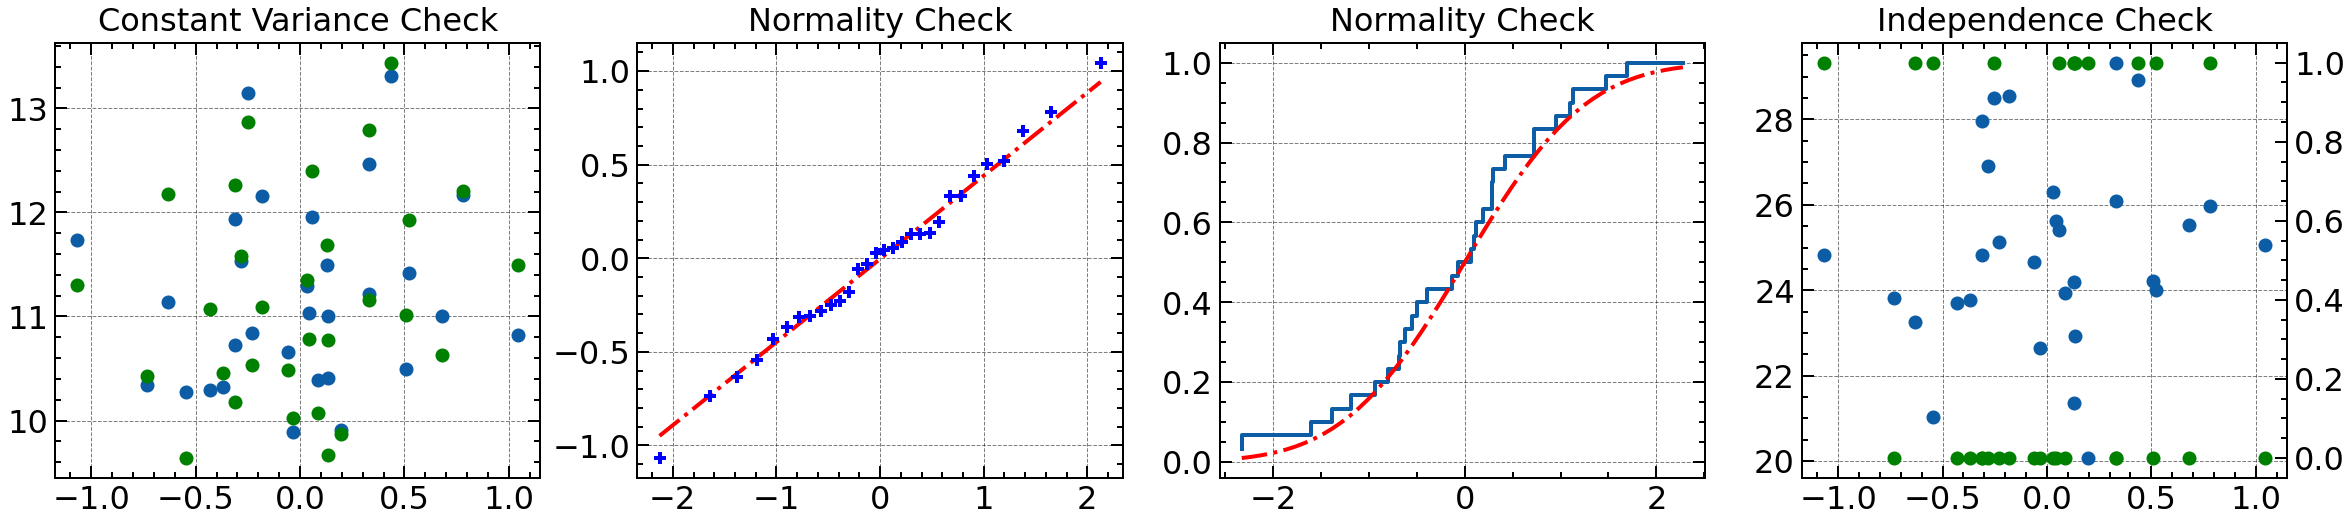

In [7]:
# Calculating residuals and predicted values.
residuals = Z_sse
z_hat = H_hat @ Z

# Check constant variance across observations/predicted values
fig, axs = plt.subplots(1, 4)
axs[0].scatter(residuals, z_hat)
axs[0].scatter(residuals, np.log(df['bacteria_grown']), color='green')
axs[0].set_title('Constant Variance Check')

# Check normality with qq plot
from utils.qq_plot import qq_plot_normal
qq_plot_normal(residuals, 'Normality Check', axs[1])

# Check normaility with ecdf plot
from utils.ecdf_plot import ecdf_normal
ecdf_normal(residuals, 'Normality Check', axs[2])

# Check independence of features
axs[3].scatter(residuals, df['tempreature'])
ax3 = axs[3].twinx()
ax3.scatter(residuals, df['humiditiy'], color='green')
ax3.grid(False)
axs[3].set_title('Independence Check')

fig.set_size_inches(20, 4)
plt.show()

### Confidence and Prediction Intervals

With a valid linear model we can begin using statstical inference. One application is to make confidence intervals for the mean $\mu_Z = \mathbb{E}[Z]$ and $\mu_Y = \mathbb{E}[Y]$. Also, it is possible to make predictions for new observations beyond the training data. One can construct intervals for these predictions, called prediction intervals.

### Confidence and Prediction Bands